<a href="https://colab.research.google.com/github/taresh18/my-ML-library/blob/master/MLlibrary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# importing the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [0]:
class MLlibrary(object):  # parent class containing the common functions used in algorithms

    def __init__(self, train_data_filename, test_data_filename):
        self.train_data_filename = train_data_filename
        self.test_data_filename = test_data_filename

    def load_dataset(self):  # creating dataframes of train and test dataset
        train_dataset = pd.read_csv(self.train_data_filename)
        test_dataset = pd.read_csv(self.test_data_filename)
        train_and_test = [train_dataset, test_dataset]
        return train_and_test

    def data_initialisation(self, train_and_test=None):  # extracting features and targets from input dataset
        train_and_test = self.load_dataset()
        train_feature_matrix = np.array(train_and_test[0])
        test_feature_matrix = np.array(train_and_test[1])

        # adding an additional column to features arrays to account for biased features
        train_feature_matrix = train_feature_matrix[:, 1:]
        test_feature_matrix = test_feature_matrix[:, 1:]
        train_features = np.ones((np.shape(train_feature_matrix)[0], np.shape(train_feature_matrix)[1] + 1), dtype=int)
        test_features = np.ones((np.shape(test_feature_matrix)[0], np.shape(test_feature_matrix)[1] + 1), dtype=int)
        train_features[:, 1:] = train_feature_matrix
        test_features[:, 1:] = test_feature_matrix

        train_target_matrix = np.array(train_and_test[0])
        test_target_matrix = np.array(train_and_test[1])

        train_target_matrix = train_target_matrix[:, 0]
        test_target_matrix = test_target_matrix[:, 0]

        arrays = [train_features, test_features, train_target_matrix, test_target_matrix]
        # converting arrays to well shaped numpy vectors
        arrays[2] = np.array([arrays[2]])
        arrays[2] = np.transpose(arrays[2])
        arrays[3] = np.array([arrays[3]])
        arrays[3] = np.transpose(arrays[3])
        return arrays

    def mean_normalization(self, arrays=None):  # applying mean normalisation on features
        arrays = self.data_initialisation()
        arrays[0] = ((arrays[0] - np.mean(arrays[0])) / (np.max(arrays[0]) - np.min(arrays[0])))
        arrays[1] = ((arrays[1] - np.mean(arrays[1])) / (np.max(arrays[1]) - np.min(arrays[1])))
        return arrays

In [0]:
class LinearRegression(MLlibrary):  # class for Linear Regression

    def split_data(self, train_features, train_target, split_ratio=0.8): # split training data into training and cross validation
        m = np.shape(train_features)[0]
        split_at = int(m * split_ratio)
        X_train = train_features[:split_at, :]
        Y_train = train_target[:split_at, :]
        X_cv = train_features[split_at:, :]
        Y_cv = train_target[split_at:, :]
        return X_train, Y_train, X_cv, Y_cv

    def hypothesis(self, X, theta):
        hypothesis = np.dot(X, theta)
        return hypothesis

    def cost_function(self, X, theta, y, lamda):
        hypothesis = self.hypothesis(X, theta)
        m = X.shape[0]
        theta_without_zero = theta[1:, :]
        mean_squared_error = np.square(hypothesis - y)
        cost_function = (np.sum(mean_squared_error) + lamda * np.sum(theta_without_zero))/(2.0 * m)
        return cost_function

    def gradient_descent(self, X, theta, y, lamda, alpha):
        m = np.shape(X)[0]
        hypothesis = self.hypothesis(X, theta)
        theta = theta - (alpha / m) * (np.dot(np.transpose(X), (hypothesis - y)) + lamda * theta)
        return theta

    def training(self, iterations, X_train, Y_train, lamda, alpha):
        cost_history = []
        theta = np.zeros((np.shape(X_train)[1], 1))
        for iteration in range(iterations):
            theta = self.gradient_descent(X_train, theta, Y_train, lamda, alpha)
            cost = self.cost_function(X_train, theta, Y_train, lamda)
            cost_history.append(cost)
        return theta, cost_history

    def predicting(self, X, Y, iterations, lamda, alpha):
        [theta, cost_history] = self.training(iterations, X, Y, lamda, alpha)
        prediction = self.hypothesis(X, theta)
        prediction = np.round(prediction, 0)  # rounds the prediction value to its nearest integer
        return prediction, cost_history

    def plots(self, cost_history, iterations):  # to plot cost function with iterations
        iteration = []
        for i in range(iterations):
            iteration.append(i)
        plt.grid(True)
        plt.scatter(iteration, cost_history, marker="x")
        plt.xlabel('no of iterations')
        plt.ylabel('cost_train')
        plt.show()

    def accuracy(self, prediction, Y):  # to calculate accuracy on predictions
        m = Y.shape[0]
        count = 0
        for i in range(np.shape(Y)[0]):
            if (prediction[i][0] == Y[i][0]): 
              count += 1
        accuracy = float(count) / m
        return accuracy * 100

    def LinearRegression(self, iterations, alpha, lamda):
        arrays = self.mean_normalization()
        [X_train, Y_train, X_cv, Y_cv] = self.split_data(arrays[0], arrays[2])
        [X_test, Y_test] = [arrays[1], arrays[3]]

        [prediction_train, cost_history] = self.predicting(X_train, Y_train, iterations, lamda, alpha)
        prediction_cv = self.predicting(X_cv, Y_cv, iterations, lamda, alpha)[0]
        prediction_test = self.predicting(X_test, Y_test, iterations, lamda, alpha)[0]

        accuracy_train = self.accuracy(prediction_train, Y_train)
        accuracy_cv = self.accuracy(prediction_cv, Y_cv)
        accuracy_test = self.accuracy(prediction_test, Y_test)

        self.plots(cost_history, iterations)

        print(accuracy_train, accuracy_cv, accuracy_test)

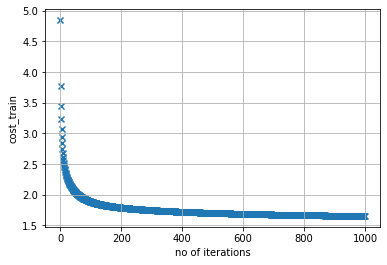

21.320082505156574 21.325 21.47214721472147


In [122]:
a = LinearRegression(r"/content/sample_data/mnist_train_small.csv",
                     r"/content/sample_data/mnist_test.csv")

a.LinearRegression(1000, 0.03, 20)  # parameters to pass=(iterations, learning rate, regularisation parameter)

In [0]:
class LogisticRegression(MLlibrary):  # class for Logistic Regression

    def split_data(self, train_features, train_target,  split_ratio = 0.8):  # split training data into training and cross validation
        m = np.shape(train_features)[0]
        split_at = int(m * split_ratio)
        X_train = train_features[:split_at, :]
        Y_train = train_target[:split_at, :]
        X_cv = train_features[split_at:, :]
        Y_cv = train_target[split_at:, :]
        return X_train, Y_train, X_cv, Y_cv

    def sigmoid(self, z):
        sigmoid = 1.0 / (1.0 + np.exp(-z))
        return sigmoid

    def hypothesis(self, X, theta):
        z = np.dot(X, theta)
        hypothesis = self.sigmoid(z)
        return hypothesis

    def cost_function(self, X, theta, y, lamda):
        m = y.size
        cross_entropy = -(y * np.log(self.hypothesis(X, theta))) - ((1 - y) * np.log(1 - self.hypothesis(X, theta)))
        theta_without_zero = theta[1:, :]
        cost_function = np.sum(cross_entropy)/m + (lamda/2.0 * m) * np.sum(np.square(theta_without_zero))
        return cost_function

    def gradient_descent(self, X, theta, y, lamda, alpha):
        m = np.shape(X)[0]
        hypothesis = self.hypothesis(X, theta)
        theta = theta - (alpha/m) * (np.dot(np.transpose(X), (hypothesis - y)) + lamda * theta)
        return theta

    def into_classes(self, X, y, num_classes=10): # converting target values into classes
        Y = np.zeros((np.shape(X)[0], num_classes), dtype=int)
        for i in range(num_classes):
            Y[:, i] = np.where(y[:, 0] == i, 1, 0)
        return Y

    def training(self, iterations, X_train, Y_train, lamda, alpha, num_classes=10):
        cost_history = []
        theta = np.zeros((np.shape(X_train)[1], num_classes))
        for iteration in range(iterations):
            theta = self.gradient_descent(X_train, theta, Y_train, lamda, alpha)
            cost = self.cost_function(X_train, theta, Y_train, lamda)
            #print(iteration, cost)
            cost_history.append(cost)
        return theta, cost_history

    def predicting(self, X, Y, iterations, lamda, alpha):
        [theta, cost_history] = self.training(iterations, X, Y, lamda, alpha)
        hypothesis = self.hypothesis(X, theta)
        prediction = hypothesis.argmax(axis=1)
        return prediction, cost_history

    def plots(self, cost_history, iterations):  # to plot cost function with iterations
        iteration = []
        for i in range(iterations):
            iteration.append(i)
        plt.grid(True)
        plt.scatter(iteration, cost_history, marker="x")
        plt.xlabel('no of iterations')
        plt.ylabel('cost_train')
        plt.show()

    def accuracy(self, prediction, Y):  # to calculate accuracy on predictions
        m = Y.shape[0]
        count = 0
        for i in range(m):
            if (prediction[i][0] == Y[i][0]):
              count += 1
        accuracy = float(count)/m
        return accuracy

    def LogisticRegression(self, iterations, alpha, lamda):
        arrays = self.mean_normalization()
        [X_train, Y_train, X_cv, Y_cv] = self.split_data(arrays[0], arrays[2])
        [X_test, Y_test] = [arrays[1], arrays[3]]

        Y_train_C = self.into_classes(X_train, Y_train)
        Y_cv_C = self.into_classes(X_cv, Y_cv)
        Y_test_C = self.into_classes(X_test, Y_test)

        [prediction_train, cost_history] = self.predicting(X_train, Y_train_C, iterations, lamda, alpha)
        prediction_cv = self.predicting(X_cv, Y_cv_C, iterations, lamda, alpha)[0]
        prediction_test = self.predicting(X_test, Y_test_C, iterations, lamda, alpha)[0]

        # accuracy_train = self.accuracy(prediction_train, Y_train)
        # accuracy_cv = self.accuracy(prediction_cv, Y_cv)
        # accuracy_test = self.accuracy(prediction_test, Y_test)

        self.plots(cost_history, iterations)

        # print(accuracy_train, accuracy_cv, accuracy_test)


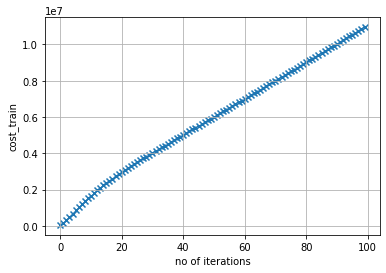

In [87]:
a = LogisticRegression(r"/content/sample_data/mnist_train_small.csv",
                     r"/content/sample_data/mnist_test.csv")

a.LogisticRegression(100, 0.03, 20)  # parameters to pass=(iterations, learning rate, regularisation parameter)

In [0]:
class KNN(MLlibrary):  # class of KNN algorithm

    def euclidean_distance(self, train_features_row, test_features_row):
        squared_distance = np.sum(np.square(train_features_row - test_features_row))
        distance = math.sqrt(squared_distance)
        return distance

    def finding_neighbours(self, train_features, train_target, test_features_row, k):
        m = np.shape(train_features)[0]
        distances = np.zeros((m, 2))
        for ith_train_row in range(m):
            distance = self.euclidean_distance(train_features[ith_train_row, :], test_features_row)
            distances[ith_train_row, 0] = train_target[ith_train_row, 0]
            distances[ith_train_row, 1] = distance
        
        abc = np.argsort(distances[:,1])
        distances = distances[abc]
        neighbours = np.zeros((k,1))
        for i in range(k):
            neighbours[i][0] = distances[i][0]

        return neighbours

    def predicting_class(self, train_features, train_target, test_features_row, k):
        neighbours = self.finding_neighbours(train_features, train_target, test_features_row, k)
        (values,counts) = np.unique(neighbours, return_counts=True)
        ind = np.argmax(counts)
        return values[ind]

    def finding_predictions(self, train_features, train_target, test_features,  k):
        m = np.shape(test_features)[0]
        predictions = np.zeros((m, 1))
        for ith_test_row in range(m):
            test_feature_row = test_features[ith_test_row]
            predictions[ith_test_row, 0] = (self.predicting_class(train_features, train_target, test_feature_row, k))
        print(predictions)
        print(test_target)

    def accuracy(self, train_features, train_target, test_features, test_target, k):  # calculate accuracy of prediction
        predictions = self.finding_predictions(train_features, train_target, test_features, k)
        m = np.shape(test_features)[0]
        count = 0
        for i in range(m):
            if predictions[i][0] == test_target[i][0]:
                count += 1
        accuracy = float(count) / m
        return accuracy

    def KNN(self, k):
        arrays = self.mean_normalization()
        self.finding_predictions(arrays[0], arrays[2], arrays[1],  k)
        #print(accuracy)

In [0]:
a = KNN(r"/content/sample_data/mnist_train_small.csv",
                     r"/content/sample_data/mnist_test.csv")
a.KNN(3)